### Neural network with feedfrward for Boston House Dataset

In [83]:
# importer
import torch 
import os 
import sys
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from typing import Dict, List, Tuple
sys.path.append(os.path.abspath(".."))
from ml_utils import parse_config, activation_decode, vizualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Constants

In [84]:
VALID_JSON = {
    "type":"object",
    "properties":
    {
        "data":
        {
            "type":"object",
            "property":
            {
                "path":
                {
                    "type":"string"
                },
                "src":
                {
                    "type":"array",
                    "items":
                    {
                        "type":"string",
                    }
                },
                "trg":
                {
                    "type":"string"
                },
                "test_size":
                {
                    "type":"integer",
                    "minimum":1,
                    "maximum":100
                }
            },
            "required":["path", "src", "trg", "test_size"]
        },
        "nn_config":
        {
            "type":"object",
            "properties":
            {
                "epochs":
                {
                    "type":"integer"
                },
                "batch_size":
                {
                    "type":"integer",
                },
                "act_f":
                {
                    "type":"string",
                    "enum": ["identity", "relu", "sig"]
                },
                "learning_rate":
                {
                    "type":"number",
                    "minimum": 0.0,
                    "maximum":1.0
                },
                "hidden_cnt":
                {
                    "type":"integer"
                },
                "hidden_size":
                {
                    "type":"integer"
                }
            },  
            "required":["epochs", "batch_size", "act_f", "learning_rate", "hidden_size","hidden_cnt"]
        }
    },
    "required":["data","nn_config"]
}

### Model

In [85]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size:int, hidden_size:int, hidden_cnt:int, act_f:str)->None:
        super().__init__()
        self._input_size = input_size
        self._hidden_cnt = hidden_cnt
        self._activation = activation_decode(act_f)
        self._body = self._generate_architecture(self._input_size, hidden_size, hidden_cnt)
    
    def _generate_architecture(self, input_size:int, hidden_size:int, hidden_cnt:int)->nn.ModuleList:
        hidden = nn.ModuleList()
        hidden.append(nn.Linear(input_size, hidden_size))
        for _ in range(hidden_cnt):
            hidden.append(nn.Linear(hidden_size, hidden_size))
        hidden.append(nn.Linear(hidden_size, 1))
        return hidden

    def forward(self, x):
        x = x.view(-1, self._input_size)
        l = len(self._body)-1
        for i, layer in enumerate(self._body):
            x = layer(x)
            if i != l:
                x = self._activation(x)
        return x

### My Dataset

In [86]:

class Data(Dataset):
    def __init__(self, X:np.ndarray, y:np.ndarray) -> None:
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
    
    def __getitem__(self, index) -> Tuple:
        return self.X[index], self.y[index]
    
    def __len__(self) -> int:
        return self.len

### Working with inputs data

In [87]:
def extract_learn_data(config:Dict)->Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(config['data']['path'])
    if not config['data']['trg'] in df.columns:
        raise Exception(f'Unkown target label {config['data']['trg']}')
    if not set(config['data']['src']).issubset(df.columns):
        raise Exception(f'In source label exist unknown label.]\nInput source labels:{config['data']['src']}\nKnown labels:{df.columns}')
    X = df.loc[:, config['data']['src']].to_numpy()
    y = df.get(config['data']['trg']).to_numpy()
    return X, y

def prepare_learn_data(config:Dict, X_scaler:StandardScaler, y_scaler:StandardScaler)->Tuple[DataLoader, DataLoader]:
    X, y = extract_learn_data(config)
    y = y.reshape(-1, 1)
    X = X_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['data']['test_size']/100,random_state=42)
    return Data(X_train, y_train), Data(X_test, y_test)


### Learning process

In [88]:
def train(config:Dict, device:torch.device, model:NeuralNetwork , criterion:nn.MSELoss, optimizer:Adam, train_loader:DataLoader):
    y_loss = np.array([])
    x_epochs = np.array([])
    model.train()
    for epoch in range(config['nn_config']['epochs']):
        running_loss = 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        x_epochs = np.append(x_epochs, epoch)
        y_loss = np.append(y_loss, running_loss/len(train_loader))
        print(f'Epoch {epoch+1} finished with avg loss: {running_loss/len(train_loader):.4f}')
    vizualization(x_epochs, "epochs", y_loss, "loss", "loss over epochs")
 
def test(device:torch.device, model:NeuralNetwork, test_loader:DataLoader, y_scaler:StandardScaler, criterion):
    model.eval()
    with torch.no_grad():
        loss = 0
        for banchs, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            outputs = torch.from_numpy(y_scaler.inverse_transform(model(data)))
            target = torch.from_numpy(y_scaler.inverse_transform(target))
            loss += criterion(outputs, target)
        print(f'MSE Loss: {loss / (banchs + 1):.5f}')

def learning(config:Dict):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_scaler, y_scaler = StandardScaler(), StandardScaler()
    train_data, test_data = prepare_learn_data(config, X_scaler, y_scaler)
    train_loader = DataLoader(train_data, batch_size=config['nn_config']['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config['nn_config']['batch_size'], shuffle=True)
    model = NeuralNetwork(train_data.X.shape[1], config['nn_config']['hidden_size'], config['nn_config']['hidden_cnt'], config['nn_config']['act_f']).to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), config['nn_config']['learning_rate'])
    train(config, device,model, criterion, optimizer, train_loader)
    test(device, model, test_loader, y_scaler, criterion)


### Show relation between 

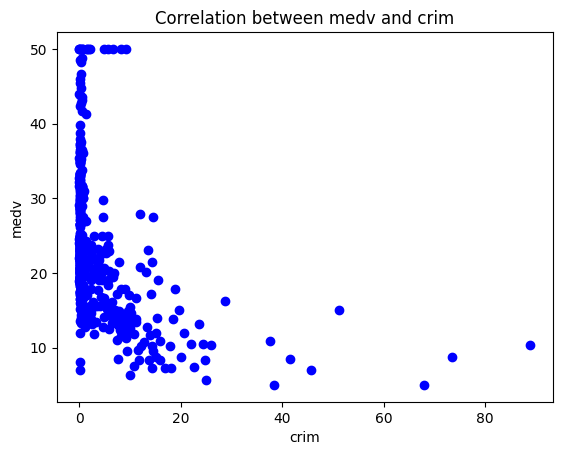

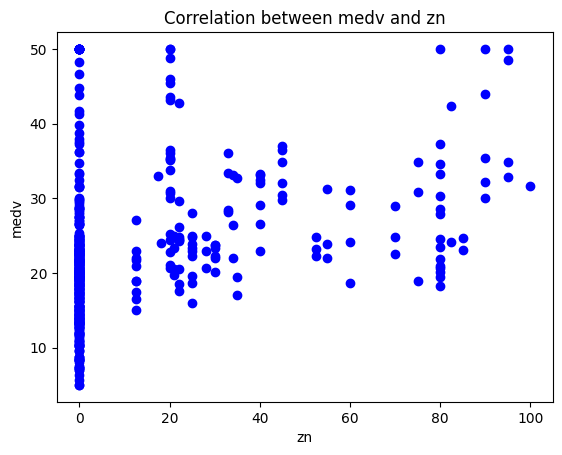

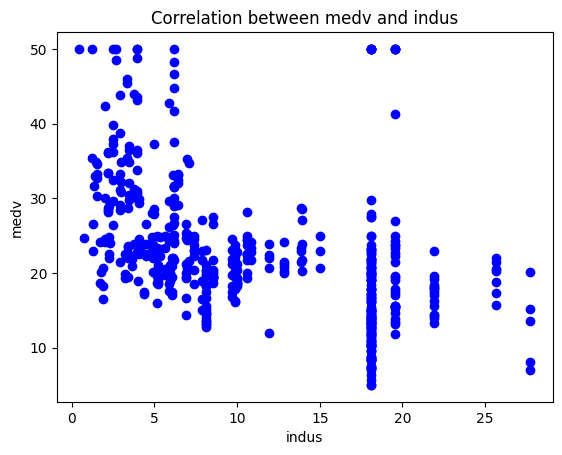

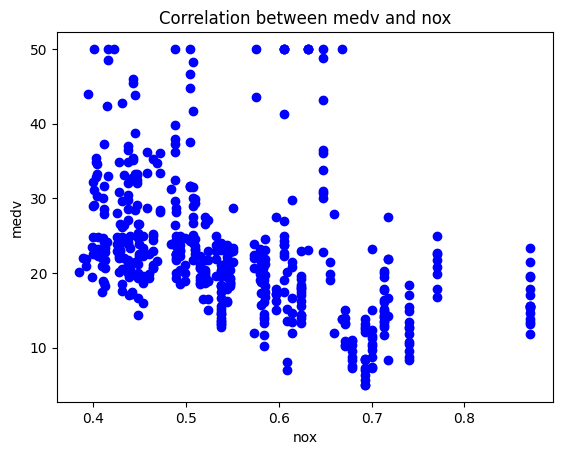

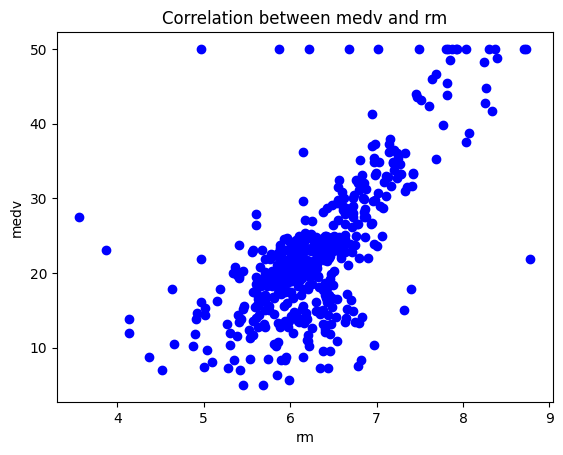

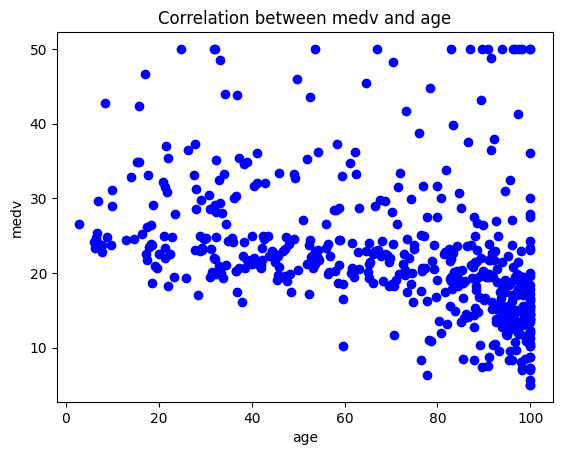

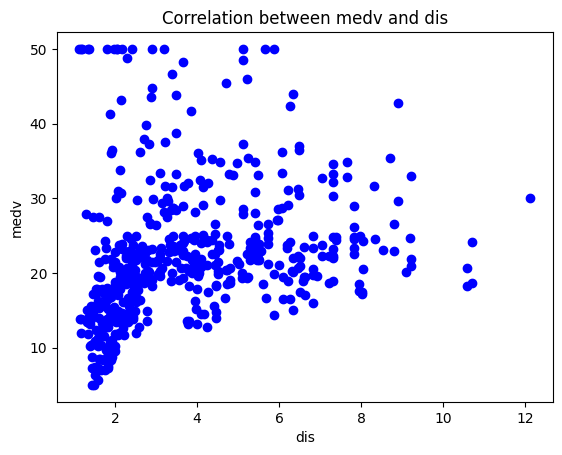

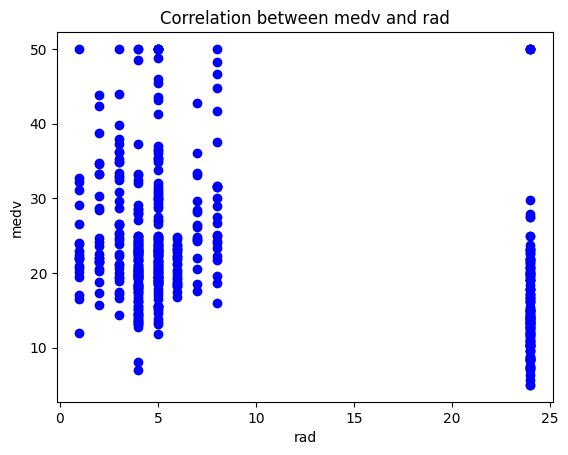

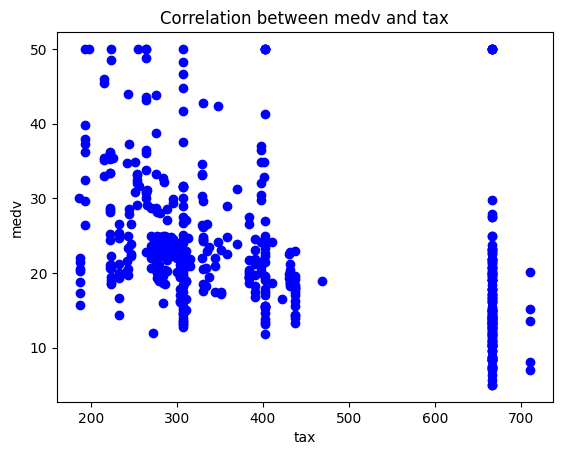

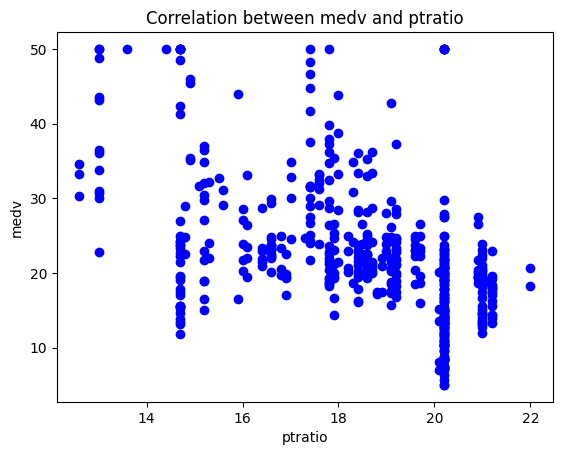

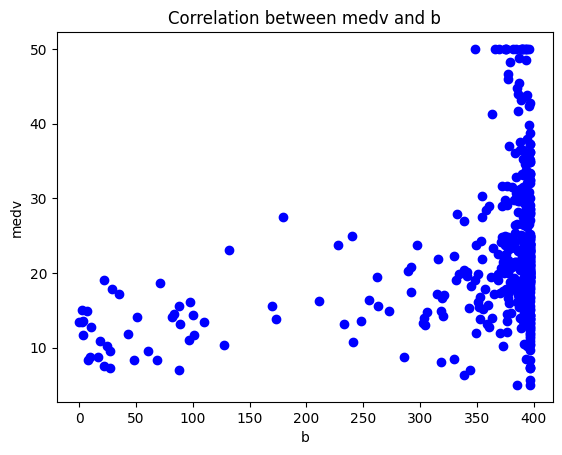

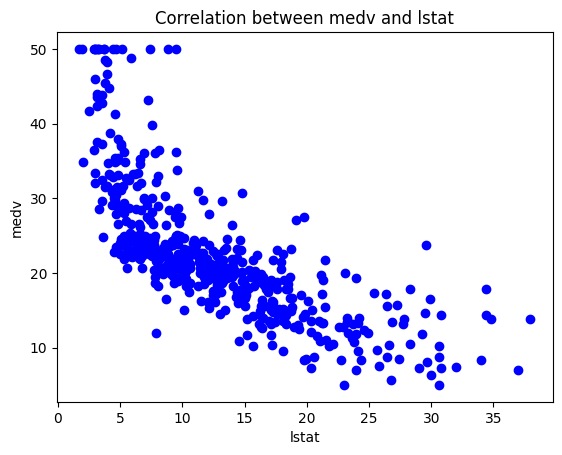

In [89]:
df = pd.read_csv('data/BostonHousing.csv')
labels = df.columns.drop('medv').drop('chas')
for label in labels:
    plt.scatter(df.get(label).to_numpy(), df.get('medv').to_numpy(), marker='o', color='blue')
    plt.xlabel(label)
    plt.ylabel('medv')
    plt.title(f'Correlation between medv and {label}')
    plt.show()

### Test 1
Use all untargets value like source

Epoch 1 finished with avg loss: 0.5676
Epoch 2 finished with avg loss: 0.4218
Epoch 3 finished with avg loss: 0.3834
Epoch 4 finished with avg loss: 0.3713
Epoch 5 finished with avg loss: 0.3674
Epoch 6 finished with avg loss: 0.3616
Epoch 7 finished with avg loss: 0.3580
Epoch 8 finished with avg loss: 0.3483
Epoch 9 finished with avg loss: 0.3507
Epoch 10 finished with avg loss: 0.3509


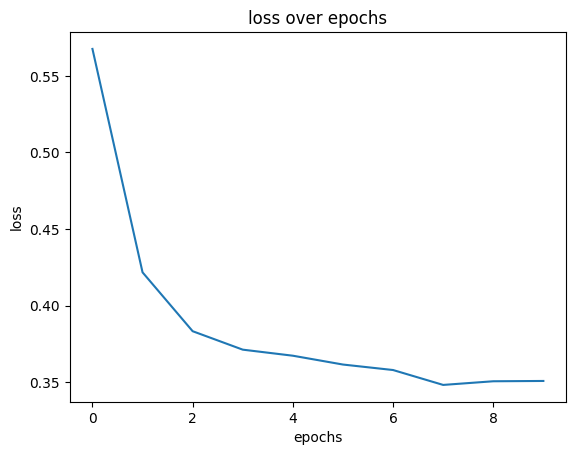

MSE Loss: 24.61519


In [90]:
config = parse_config('config/config1.json', VALID_JSON)
learning(config)

### Test 2
Use more epochs

Epoch 1 finished with avg loss: 0.6818
Epoch 2 finished with avg loss: 0.4404
Epoch 3 finished with avg loss: 0.4057


Epoch 4 finished with avg loss: 0.3912
Epoch 5 finished with avg loss: 0.3838
Epoch 6 finished with avg loss: 0.3708
Epoch 7 finished with avg loss: 0.3591
Epoch 8 finished with avg loss: 0.3521
Epoch 9 finished with avg loss: 0.3555
Epoch 10 finished with avg loss: 0.3477
Epoch 11 finished with avg loss: 0.3440
Epoch 12 finished with avg loss: 0.3379
Epoch 13 finished with avg loss: 0.3431
Epoch 14 finished with avg loss: 0.3365
Epoch 15 finished with avg loss: 0.3377
Epoch 16 finished with avg loss: 0.3355
Epoch 17 finished with avg loss: 0.3372
Epoch 18 finished with avg loss: 0.3314
Epoch 19 finished with avg loss: 0.3402
Epoch 20 finished with avg loss: 0.3461
Epoch 21 finished with avg loss: 0.3502
Epoch 22 finished with avg loss: 0.3412
Epoch 23 finished with avg loss: 0.3369
Epoch 24 finished with avg loss: 0.3444
Epoch 25 finished with avg loss: 0.3277
Epoch 26 finished with avg loss: 0.3305
Epoch 27 finished with avg loss: 0.3248
Epoch 28 finished with avg loss: 0.3273
Epoch 

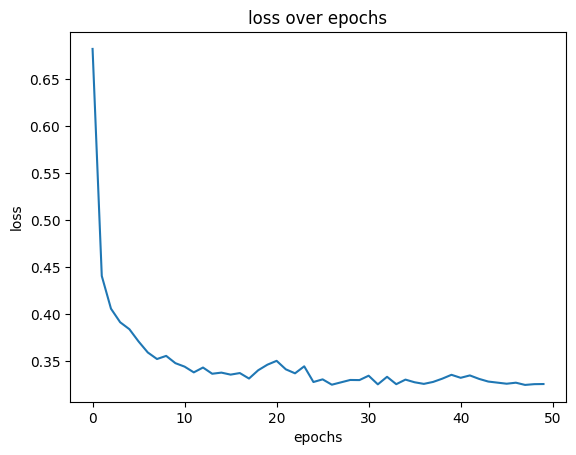

MSE Loss: 23.28141


In [91]:
config = parse_config('config/config2.json', VALID_JSON)
learning(config)

### Test 3
Use sig activation function

Epoch 1 finished with avg loss: 0.6042
Epoch 2 finished with avg loss: 0.4206
Epoch 3 finished with avg loss: 0.3703
Epoch 4 finished with avg loss: 0.3648
Epoch 5 finished with avg loss: 0.3622
Epoch 6 finished with avg loss: 0.3628
Epoch 7 finished with avg loss: 0.3633
Epoch 8 finished with avg loss: 0.3586
Epoch 9 finished with avg loss: 0.3577
Epoch 10 finished with avg loss: 0.3559


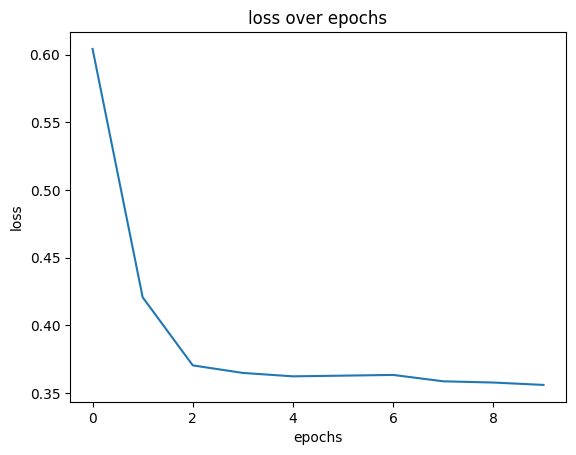

MSE Loss: 24.99554


In [92]:
config = parse_config('config/config3.json', VALID_JSON)
learning(config)

### Test 4
Use smaller(0.0001) learning rate

Epoch 1 finished with avg loss: 1.0131
Epoch 2 finished with avg loss: 0.8333
Epoch 3 finished with avg loss: 0.6963
Epoch 4 finished with avg loss: 0.5973
Epoch 5 finished with avg loss: 0.5318
Epoch 6 finished with avg loss: 0.4851
Epoch 7 finished with avg loss: 0.4540
Epoch 8 finished with avg loss: 0.4333
Epoch 9 finished with avg loss: 0.4194
Epoch 10 finished with avg loss: 0.4098


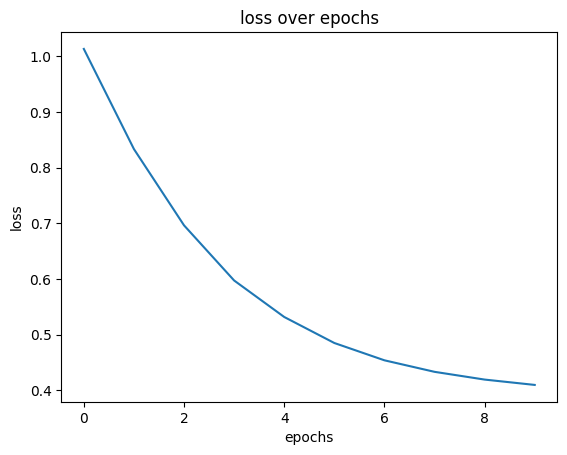

MSE Loss: 28.28527


In [93]:
config = parse_config('config/config4.json', VALID_JSON)
learning(config)

### Test 5
Use more inputs(526) to neuron

Epoch 1 finished with avg loss: 0.5377
Epoch 2 finished with avg loss: 0.3635
Epoch 3 finished with avg loss: 0.3454
Epoch 4 finished with avg loss: 0.3433
Epoch 5 finished with avg loss: 0.3520
Epoch 6 finished with avg loss: 0.3502
Epoch 7 finished with avg loss: 0.3378
Epoch 8 finished with avg loss: 0.3400
Epoch 9 finished with avg loss: 0.3331
Epoch 10 finished with avg loss: 0.3303


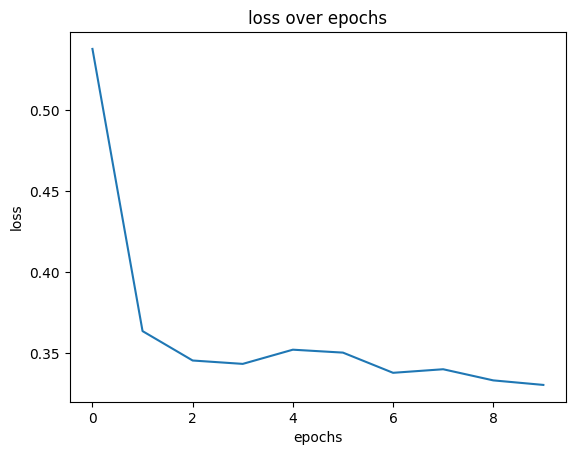

MSE Loss: 24.13867


In [94]:
config = parse_config('config/config5.json', VALID_JSON)
learning(config)

### Test 6
Less inputs(10) to neuron

Epoch 1 finished with avg loss: 1.1686
Epoch 2 finished with avg loss: 1.1166
Epoch 3 finished with avg loss: 1.0720
Epoch 4 finished with avg loss: 1.0342
Epoch 5 finished with avg loss: 0.9860
Epoch 6 finished with avg loss: 0.9457
Epoch 7 finished with avg loss: 0.8960
Epoch 8 finished with avg loss: 0.8471
Epoch 9 finished with avg loss: 0.7965
Epoch 10 finished with avg loss: 0.7470
Epoch 11 finished with avg loss: 0.6987
Epoch 12 finished with avg loss: 0.6486
Epoch 13 finished with avg loss: 0.6109
Epoch 14 finished with avg loss: 0.5716
Epoch 15 finished with avg loss: 0.5349
Epoch 16 finished with avg loss: 0.5112
Epoch 17 finished with avg loss: 0.4883
Epoch 18 finished with avg loss: 0.4675
Epoch 19 finished with avg loss: 0.4549
Epoch 20 finished with avg loss: 0.4412
Epoch 21 finished with avg loss: 0.4353
Epoch 22 finished with avg loss: 0.4265
Epoch 23 finished with avg loss: 0.4195
Epoch 24 finished with avg loss: 0.4117
Epoch 25 finished with avg loss: 0.4094
Epoch 26 

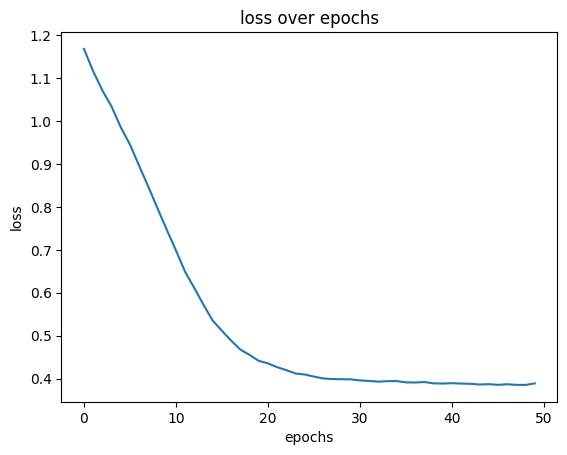

MSE Loss: 27.35836


In [95]:
config = parse_config('config/config6.json', VALID_JSON)
learning(config)

### Test 7
Use deeper neuron net(5 neurons)

Epoch 1 finished with avg loss: 0.9203
Epoch 2 finished with avg loss: 0.5828
Epoch 3 finished with avg loss: 0.4393
Epoch 4 finished with avg loss: 0.4327
Epoch 5 finished with avg loss: 0.4189
Epoch 6 finished with avg loss: 0.3757
Epoch 7 finished with avg loss: 0.3509
Epoch 8 finished with avg loss: 0.3703
Epoch 9 finished with avg loss: 0.3641
Epoch 10 finished with avg loss: 0.3797


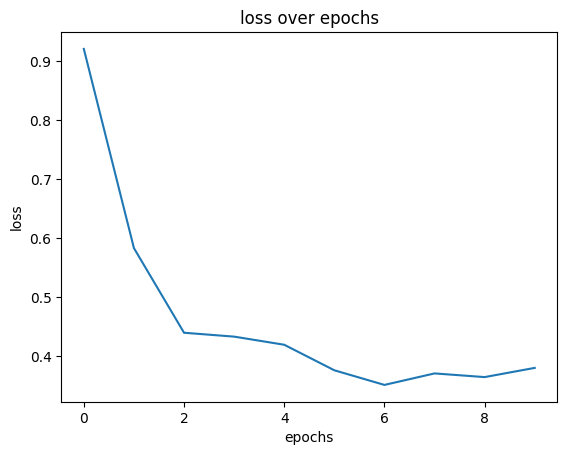

MSE Loss: 29.37309


In [96]:
config = parse_config('config/config7.json', VALID_JSON)
learning(config)